In [4]:
# 1. Install packages
!pip install torch nltk scikit-learn pandas matplotlib

In [6]:
# 2. Import libraries
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score




In [7]:
# 3. Load dataset
df = pd.read_csv('review_20242025_standard.csv')
df = df[['review', 'sentiment']].dropna()
df.head()

review  sentiment
0  "\"The Classic War of the Worlds\" by Timothy ...          1
1  "The film starts with a manager (Nicholas Bell...          0
2  "Superbly trashy and wondrously unpretentious ...          1
3  "I dont know why people think this is such a b...          1
4  "This movie could have been very good, but com...          0

In [14]:
# 4. Text preprocessing
# Define a tokenizer that also lowercases the text
def simple_tokenizer(text):
    if isinstance(text, str):
        return re.findall(r'\b\w+\b', text.lower())
    else:
        return []



In [16]:
# 5. Tokenize text

# Apply the tokenizer directly
df['tokens'] = df['review'].apply(simple_tokenizer)

# View results
print(df[['review', 'tokens']].head())

                                              review  \
0  "\"The Classic War of the Worlds\" by Timothy ...   
1  "The film starts with a manager (Nicholas Bell...   
2  "Superbly trashy and wondrously unpretentious ...   
3  "I dont know why people think this is such a b...   
4  "This movie could have been very good, but com...   

                                              tokens  
0  [the, classic, war, of, the, worlds, by, timot...  
1  [the, film, starts, with, a, manager, nicholas...  
2  [superbly, trashy, and, wondrously, unpretenti...  
3  [i, dont, know, why, people, think, this, is, ...  
4  [this, movie, could, have, been, very, good, b...  


In [18]:
# Review lengths
df['review_length'] = df['tokens'].apply(len)

# Class distribution
print("Class Distribution:")
print(df['sentiment'].value_counts(), "\n")

# Review length stats
print("Average review length:", df['review_length'].mean())
print("Max review length:", df['review_length'].max())
print("Min review length:", df['review_length'].min())


Class Distribution:
sentiment
1    10565
0    10565
Name: count, dtype: int64 

Average review length: 242.91239943208708
Max review length: 2525
Min review length: 10


In [20]:
# Word frequency
from collections import Counter

all_words = [word for tokens in df['tokens'] for word in tokens]
word_freq = Counter(all_words).most_common(10)  # Top 30

# Convert to DataFrame
word_freq_df = pd.DataFrame(word_freq, columns=['Word', 'Frequency'])
print("\nTop 10 Frequent Words:")
print(word_freq_df)



Top 10 Frequent Words:
  Word  Frequency
0  the     284912
1  and     138883
2    a     138294
3   of     123514
4   to     114830
5   is      90962
6   br      86269
7   it      81561
8   in      79449
9    i      74221


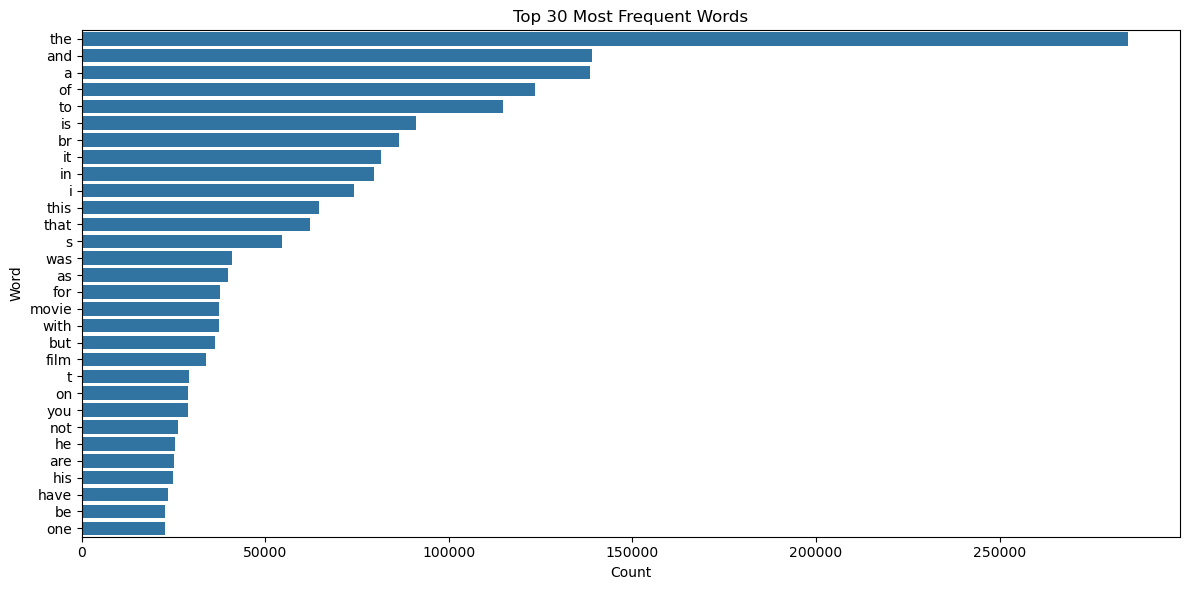

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,6))
sns.barplot(x='Frequency', y='Word', data=word_freq_df)
plt.title("Top 30 Most Frequent Words")
plt.xlabel("Count")
plt.ylabel("Word")
plt.tight_layout()
plt.show()


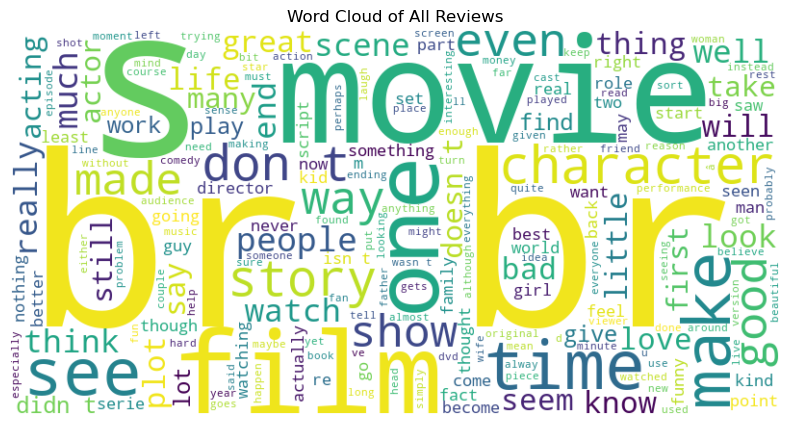

In [9]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of All Reviews")
plt.show()


Negative reviews - Avg: 231.23, Std: 167.62, Max: 1522
Positive reviews - Avg: 237.29, Std: 180.05, Max: 2470


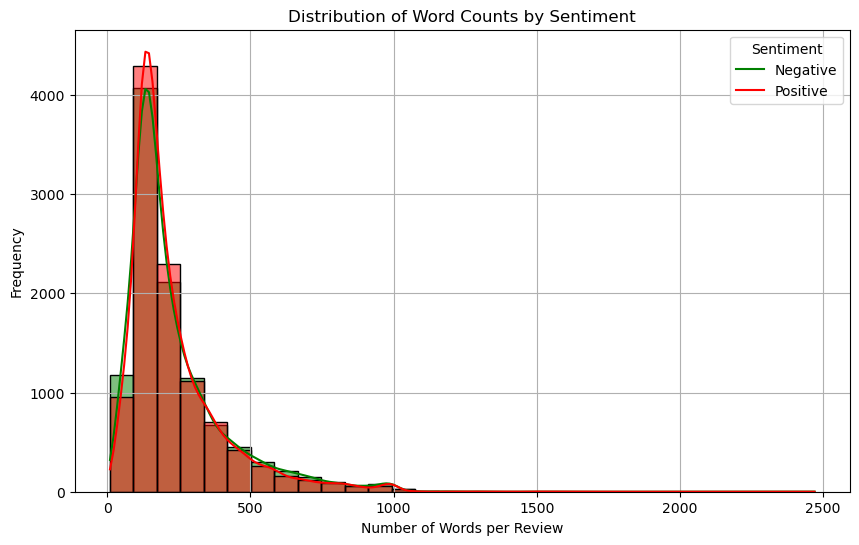

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Compute word counts
df['word_count'] = df['review'].apply(lambda x: len(str(x).split()))

# Print stats
for label, sentiment in [(0, "Negative"), (1, "Positive")]:
    subset = df[df['sentiment'] == label]['word_count']
    print(f"{sentiment} reviews - Avg: {np.mean(subset):.2f}, Std: {np.std(subset):.2f}, Max: {np.max(subset)}")

# Plot
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='word_count', hue='sentiment', bins=30, kde=True, palette={0: "red", 1: "green"})
plt.title("Distribution of Word Counts by Sentiment")
plt.xlabel("Number of Words per Review")
plt.ylabel("Frequency")
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.grid(True)

# Save to PDF
plt.savefig("word_count_by_sentiment.pdf", format="pdf")
plt.show()


In [11]:
# 6. Build vocabulary from training data
from collections import Counter

all_tokens = [token for tokens in df['tokens'] for token in tokens]
word_counts = Counter(all_tokens)
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.items())}  # start from 2
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

In [12]:
# 7. Encode tokens into integers
def encode_tokens(tokens):
    return [vocab.get(token, 1) for token in tokens]  # 1 is <UNK>

df['encoded'] = df['tokens'].apply(encode_tokens)

In [13]:
# 8. Pad sequences
from torch.nn.utils.rnn import pad_sequence

max_len = 600 

def pad_seq(seq):
    return seq[:max_len] + [0]*(max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

df['padded'] = df['encoded'].apply(pad_seq)

In [14]:
# 9. Load GloVe embeddings

import os
import zipfile
import urllib.request

# Step 1: Download using urllib
glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = "glove.6B.zip"

if not os.path.exists(glove_zip_path):
    print("Downloading GloVe embeddings...")
    urllib.request.urlretrieve(glove_url, glove_zip_path)

# Step 2: Unzip
glove_folder = "glove"
if not os.path.exists(glove_folder):
    print("Unzipping GloVe embeddings...")
    with zipfile.ZipFile(glove_zip_path, "r") as zip_ref:
        zip_ref.extractall(glove_folder)


In [15]:
# 9. Load GloVe embeddings

embedding_dim = 300
glove_path = "glove/glove.6B.300d.txt"

# Build embedding matrix
embedding_matrix = np.random.normal(0, 1, (len(vocab), embedding_dim))
with open(glove_path, 'r', encoding='utf8') as f:
    for line in f:
        parts = line.strip().split()
        word = parts[0]
        vector = np.array(parts[1:], dtype=np.float32)
        if word in vocab:
            idx = vocab[word]
            embedding_matrix[idx] = vector



In [16]:
# 10. Create Dataset and Dataloader
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels):
        self.reviews = torch.tensor(reviews, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.reviews[idx], self.labels[idx]


# Split
X_train, X_test, y_train, y_test = train_test_split(df['padded'].tolist(), df['sentiment'].tolist(), test_size=0.2, random_state=42)
train_dataset = ReviewDataset(X_train, y_train)
test_dataset = ReviewDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32) #这个可能要往小调， batch size

In [17]:
# 11. Define LSTM model

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, embedding_weights, dropout=0.5):
        super().__init__()
        
        self.embedding = nn.Embedding.from_pretrained(
            torch.tensor(embedding_weights, dtype=torch.float32),
            freeze=False
        )
        
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        output, (hidden, _) = self.lstm(embedded)

        # hidden is [num_layers * num_directions, batch, hidden_dim]
        # Concatenate the final forward and backward hidden states
        hidden_fw = hidden[-2, :, :]  # forward
        hidden_bw = hidden[-1, :, :]  # backward
        hidden_cat = torch.cat((hidden_fw, hidden_bw), dim=1)

        dropped = self.dropout(hidden_cat)
        output = self.fc(dropped)
        return self.sigmoid(output).squeeze(1)  # [batch_size]



In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = LSTMModel(
    vocab_size=len(vocab),
    embedding_dim=embedding_dim,
    hidden_dim=128,
    output_dim=1,
    embedding_weights=embedding_matrix,
    dropout=0.5).to(device)


In [19]:
# 13. Train the model
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 5

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

Epoch 1, Loss: 0.5977
Epoch 2, Loss: 0.3737
Epoch 3, Loss: 0.1689
Epoch 4, Loss: 0.0573
Epoch 5, Loss: 0.0201


In [20]:
# 14. Evaluate
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()
        preds = (outputs >= 0.5).astype(int)
        y_pred.extend(preds)
        y_true.extend(labels.numpy())



In [21]:
# 15. Report
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
print("Classification Report:\n", classification_report(y_true, y_pred))


Accuracy: 0.8583
Confusion Matrix:
 [[1751  336]
 [ 263 1876]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.87      0.84      0.85      2087
         1.0       0.85      0.88      0.86      2139

    accuracy                           0.86      4226
   macro avg       0.86      0.86      0.86      4226
weighted avg       0.86      0.86      0.86      4226



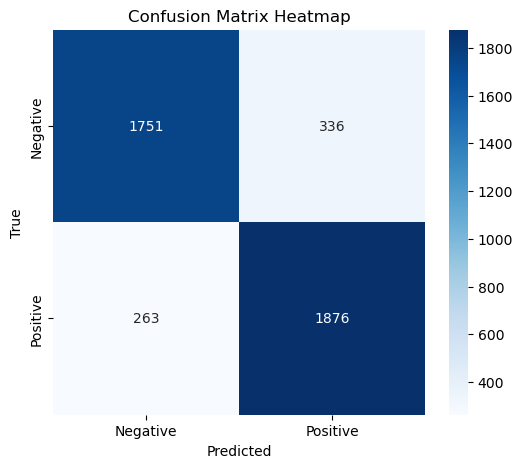

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# After collecting y_true and y_pred
cm = confusion_matrix(y_true, y_pred)

# Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()


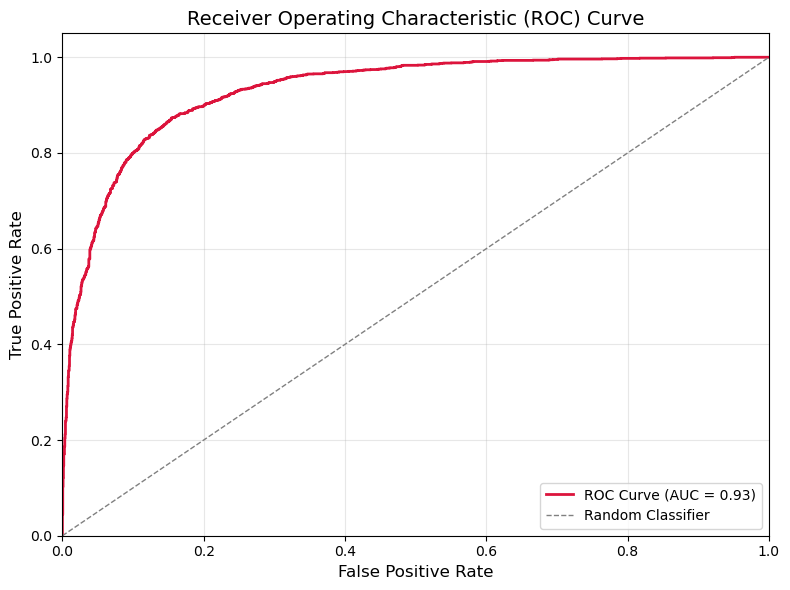

In [76]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities
model.eval()
y_true = []
y_scores1 = []


with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs).squeeze().cpu().numpy()  # sigmoid probabilities
        y_scores1.extend(outputs)
        y_true.extend(labels.numpy())

# Compute ROC curve and AUC
fpr_1, tpr_1, thresholds = roc_curve(y_true, y_scores1)
roc_auc = auc(fpr_1, tpr_1)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_1, tpr_1, color='crimson', lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Random Classifier')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

np.save("y_true_model1.npy", y_true)
np.save("y_scores_model1.npy", y_scores1)





In [24]:
# 16. Predict sentiment for a new review
def preprocess_and_encode(text, vocab, max_len=100): #0.88这个是100
    tokens = re.findall(r'\b\w+\b', text.lower())
    encoded = [vocab.get(token, 1) for token in tokens]  # 1 is <UNK>
    padded = encoded[:max_len] + [0] * (max_len - len(encoded)) if len(encoded) < max_len else encoded[:max_len]
    return torch.tensor(padded, dtype=torch.long).unsqueeze(0)  # Add batch dimension

def predict_sentiment(text):
    model.eval()
    input_tensor = preprocess_and_encode(text, vocab).to(device)
    with torch.no_grad():
        output = model(input_tensor)
        pred = int(output.item() >= 0.5)
        return "Positive" if pred == 1 else "Negative"

# Example usage
example_text = "This movie could have been very bad"
print("Sentiment:", predict_sentiment(example_text))

# Example usage
example_text = "This movie could have been very good"
print("Sentiment:", predict_sentiment(example_text))


Sentiment: Negative
Sentiment: Positive
